<a href="https://colab.research.google.com/github/daviddralle/salmonid_and_subsurface/blob/main/functional_flows_salmonid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and installations

In [ ]:
 import requests
def download_file(url,fn):
  r = requests.get(url, allow_redirects=True)
  open(fn, 'wb').write(r.content)

download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/peakdetect.py','peakdetect.py')
download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/lith.csv','lith.csv')
download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/teaching_data/dry_discharge.csv','dry_discharge.csv')
download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/teaching_data/elder_discharge.csv','elder_discharge.csv')
download_file('https://raw.githubusercontent.com/daviddralle/daviddralle.github.io/master/level4e.csv','level4e.csv')

!pip install -q geopandas

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from peakdetect import peakdet as peakdet
from scipy.optimize import curve_fit
import geopandas as gp
import glob
import matplotlib
import scipy.optimize as optimization
import pickle
import urllib3
import datetime
import time
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 1.0 MB 9.7 MB/s 
     |████████████████████████████████| 16.7 MB 15.1 MB/s 
     |████████████████████████████████| 6.3 MB 16.9 MB/s 


# Plot hydrographs and precipitation

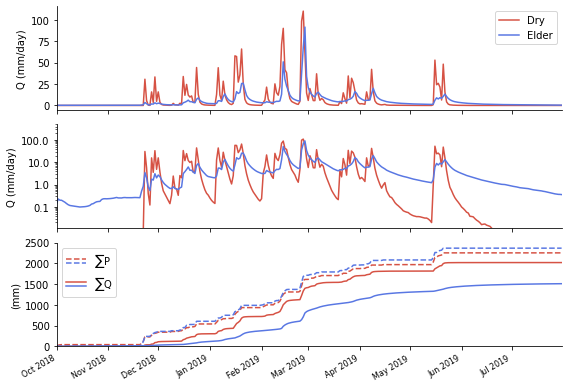

In [ ]:
cmap = matplotlib.cm.get_cmap('coolwarm')
celder = cmap(0.1)
cdry = cmap(0.9)

data = pd.read_csv('./level4e.csv',index_col=0,parse_dates=True)
dry_daily = data[['dryRunoff_mmHour^-1']].resample('D').mean()*24
dry_daily.columns = ['q']
elder_daily = data[['elder_mmHour']].resample('D').mean()*24
elder_daily.columns = ['q']

startdate = '2018-10-01'
stopdate = '2019-07-31'

elder = elder_daily.loc[startdate:stopdate]
dry = dry_daily.loc[startdate:stopdate]

f,axs = plt.subplots(3,1,figsize=(8,5.5),sharex=True)
ax = axs[0]
ax.plot(dry['q'], label='Dry',c=cdry)
ax.plot(elder['q'], label='Elder', c=celder)
ax.set_ylabel('Q (mm/day)')
sns.despine(right=True,top=True)
ax.legend()

ax = axs[1]
ax.plot(dry['q'], label='Dry',c=cdry)
ax.plot(elder['q'], label='Elder', c=celder)
ax.set_ylabel('Q (mm/day)')
ax.set_yscale('log')
ax.set_ylim([1.1e-2,5e2])
ax.set_xlim(pd.to_datetime(startdate), pd.to_datetime(stopdate))
ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
sns.despine(right=True,top=True)

cols = ['angeloPrecip-Undercatch-and-Interception-Corrected-mm', 'sagehornPrecip-Undercatch-and-Interception-Corrected-mm']
precip = 4*data[cols]
precip.columns = ['elder', 'dry']
p = precip.loc[startdate:stopdate]
p = p.resample('D').sum()

ax = axs[2]
ax.plot(p['dry'].cumsum(), label=r'$\sum$P', c=cdry,ls='--')
ax.plot(p['elder'].cumsum(),c=celder,ls='--')
ax.plot(dry['q'].cumsum(), label=r'$\sum$Q',c=cdry)
ax.plot(elder['q'].cumsum(), c=celder)
sns.despine(right=True,top=True)
ax.set_ylabel(r'(mm)')
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1))
ax.set_ylim([0,2500])
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %Y'))
labels = ax.get_xticklabels()
plt.setp(labels, rotation=85, fontsize=8)
f.autofmt_xdate()

from matplotlib.legend_handler import HandlerBase
class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.8*height,0.8*height],
                          linestyle=orig_handle[0], color=orig_handle[1])
        l2 = plt.Line2D([x0,y0+width], [0.2*height,0.2*height], 
                          color=orig_handle[2],linestyle=orig_handle[0])
        return [l1, l2]

ax.legend([('--',cdry,celder),('-',cdry,celder)], [r'$\sum$P',r'$\sum$Q'],
           handler_map={tuple: AnyObjectHandler()})

f.tight_layout()
f.savefig('wy.pdf')

# Flow activation

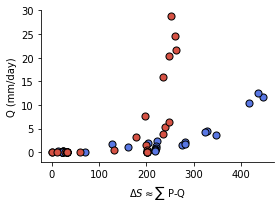

In [ ]:
plimit = 500
s = 50
f,ax = plt.subplots(1,figsize=(4,3))
year = 2016

startdate = '%s-10-01'%str(year)
stopdate = precip[startdate:].loc[precip[startdate:].elder.cumsum()>plimit].index[0]

elder = elder_daily.loc[startdate:stopdate]
dry = dry_daily.loc[startdate:stopdate]
p = precip[startdate:stopdate].resample('D').sum()

dv = (p['elder'].cumsum() - elder['q'].cumsum())
qw = elder['q']
x = dv.values
y = qw.values
ax.scatter(x, y, color=celder,s=s,ec='k',alpha=1)

dv = (p['dry'].cumsum() - dry['q'].cumsum())
qw = dry['q']
x = dv.values
y = qw.values
ax.scatter(x, y, color=cdry,s=s,ec='k',alpha=1)

ax.set_ylim([-2,30])
ax.set_xlabel(r'$\Delta S \approx \sum$ P-Q')
ax.set_ylabel('Q (mm/day)')
sns.despine(right=True,top=True)
f.tight_layout()
f.savefig('./activation.pdf')

# Peak flow

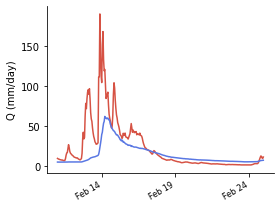

In [ ]:
p = pd.read_csv('./level4e.csv', parse_dates=True, index_col=0)
dry_q = p['dryRunoff_mmHour^-1']
elder_q = p['elder_mmHour']
startdate = '2019-02-11'
stopdate = '2019-02-24'
elder_q = 24*elder_q.loc[startdate:stopdate].resample('H').mean()
dry_q = 24*dry_q.loc[startdate:stopdate].resample('H').mean()

f,ax = plt.subplots(1,figsize=(4,3))
ax.plot(dry_q, label='Dry Creek',c=cdry)
ax.plot(elder_q, label='Elder Creek', c=celder)
ax.xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))
labels = ax.get_xticklabels()
plt.setp(labels, rotation=85, fontsize=8)
ax.set_ylabel('Q (mm/day)')
sns.despine(right=True,top=True)
f.autofmt_xdate()
f.tight_layout()
f.savefig('./peak.pdf')

# Spring and summer recession

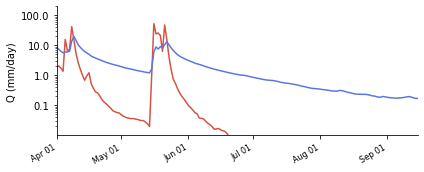

In [ ]:
p = pd.read_csv('./level4e.csv', parse_dates=True, index_col=0)
dry_q = p['dryRunoff_mmHour^-1'].resample('24H').mean()*24
elder_q = p['elder_mmHour'].resample('D').mean()*24

startdate = pd.to_datetime('2019-04-1')
stopdate = pd.to_datetime('2019-09-15')
elder_q = elder_q.loc[startdate:stopdate]
dry_q = dry_q.loc[startdate:stopdate]

f,ax = plt.subplots(1,figsize=(6,2.5))
ax.plot(dry_q, label='Dry Creek',c=cdry)
ax.plot(elder_q, label='Elder Creek', c=celder)
ax.set_ylabel('Q (mm/day)')
ax.set_xlim(startdate, stopdate)
ax.set_yscale('log')
ax.set_ylim([1.001e-2,2e2])

ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))
labels = ax.get_xticklabels()
plt.setp(labels, rotation=85, fontsize=8)
ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
f.autofmt_xdate()
sns.despine(right=True,top=True)

f.tight_layout()
f.savefig('recession.pdf')